## What is instacart?
Instacart,is  a grocery ordering and delivery app, aims to make it easy to fill
your refrigerator and pantry with your personal favourites and staples when
you need them.For each user they provide between 4 and 100 of orders.They also
provide the week and hour of day the order was placed, and a relative
measure of time between orders.


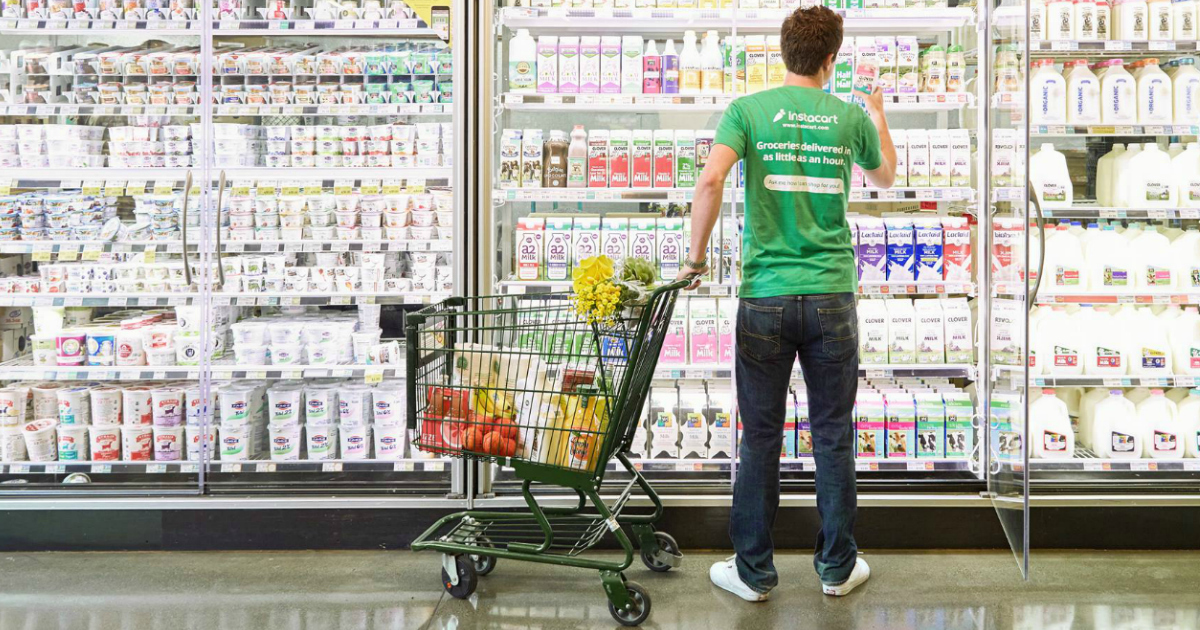

In [2]:
from PIL import Image
img = Image.open("insta6.jpg")
img

## What is the problem statement?

From given past data of customer’s orders which contains product purchased by customer in that order and  we need to predict which
products customers will repurchase in the future order.

# Business objectives
Design models that predict which products a user will buy again or add to their cart next during a session so that personal shoppers review your order and do the in-store shopping and delivery for you.

# Business constraints
No low-latency requirement.

For each order predict product with high precision and recall

# Performance metric

Mean f1-Score:  Here for each order_id we calculate f1 score than take average of   all order's f1_score.


ROC-AUC

LIBRARIES

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

READING FILES

In [2]:
order_products_prior_data = pd.read_csv("/content/drive/MyDrive/instcart/order_products__prior.csv")
order_products_train_data = pd.read_csv("/content/drive/MyDrive/instcart/order_products__train.csv")
orders_data= pd.read_csv("/content/drive/MyDrive/instcart/orders.csv")
product_data = pd.read_csv("/content/drive/MyDrive/instcart/products.csv")
aisles_data= pd.read_csv("/content/drive/MyDrive/instcart/aisles.csv")
departments_data = pd.read_csv("/content/drive/MyDrive/instcart/departments.csv")

## 1. DATA OVERVIEW

# order_products_prior_data

In [ ]:
print(order_products_prior_data.shape)
order_products_prior_data.head()

(32434489, 4)


,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [ ]:
#missing values
order_products_prior_data.isnull().sum()

order_id             0
product_id           0
add_to_cart_order    0
reordered            0
dtype: int64

If order_id value present in order_products_prior_data than it is not in order_products_train_data

## order_products_train_data 

In [ ]:
print(order_products_train_data.shape)
order_products_train_data.head()

(1384617, 4)


,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


In [ ]:
order_products_train_data.isnull().sum()

order_id             0
product_id           0
add_to_cart_order    0
reordered            0
dtype: int64

#  orders_data
here we have 206209  unique users and 3421083 unique orders

In [ ]:
print(orders_data.shape)
orders_data.head()

(3421083, 7)


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [ ]:
orders_data.isnull().sum()

order_id                       0
user_id                        0
eval_set                       0
order_number                   0
order_dow                      0
order_hour_of_day              0
days_since_prior_order    206209
dtype: int64

Here, In orders_data feature days_since_prior_order has many missing values for each user first order has missing value for this  feature so we have 206209 unique user and 206209 missing values for their first order  feature days_since_prior_order.

In [ ]:
unique_orders=len(orders_data['order_id'].unique())
print("total unique orders are",unique_orders)
unique_users=len(orders_data['user_id'].unique())
print("total unique users are",unique_users)

total unique orders are 3421083
total unique users are 206209


## product_data

In [ ]:
print(product_data.shape)
product_data.head()

(49688, 4)


,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [ ]:
product_data.isnull().sum()

product_id       0
product_name     0
aisle_id         0
department_id    0
dtype: int64

In [ ]:
print('total unique products are',len(product_data['product_id'].unique()))

total unique products are 49688


## aisles_data

In [ ]:
print(aisles_data.shape)
aisles_data.head()

(134, 2)


,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [ ]:
aisles_data.isnull().sum()

aisle_id    0
aisle       0
dtype: int64

## departments_data

In [ ]:
print(departments_data.shape)
departments_data.head(2)

(21, 2)


,department_id,department
0,1,frozen
1,2,other


In [ ]:
print('total departments are',len(departments_data['department_id'].unique()))
departments_data.isnull().sum()

total departments are 21


department_id    0
department       0
dtype: int64

Reduce memory consumed by dataframe

In [3]:
# references URL : https://www.kaggle.com/rinnqd/reduce-memory-usage
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

# Merge data

->merge order_products_prior_data and order_products_train_data dataframe

In [4]:
order_train_prior = pd.concat([order_products_prior_data , order_products_train_data])
print(order_train_prior.shape)
order_train_prior.head()

(33819106, 4)


,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


Merge orders_data with order_train_prior so that we get information about order

In [5]:
data=pd.merge(orders_data,order_train_prior,on="order_id")
print(data.shape)
data.head()

(33819106, 10)


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered
0,2539329,1,prior,1,2,8,NaN,196,1,0
1,2539329,1,prior,1,2,8,NaN,14084,2,0
2,2539329,1,prior,1,2,8,NaN,12427,3,0
3,2539329,1,prior,1,2,8,NaN,26088,4,0
4,2539329,1,prior,1,2,8,NaN,26405,5,0


In [ ]:
data.to_csv('/content/drive/MyDrive/instcart/merge of order data with train and prior',index=False)

In [ ]:
data=pd.read_csv("/content/drive/MyDrive/instcart/merge of order data with train and prior")

In [ ]:
data.columns

Index(['order_id', 'user_id', 'eval_set', 'order_number', 'order_dow',
       'order_hour_of_day', 'days_since_prior_order', 'product_id',
       'add_to_cart_order', 'reordered'],
      dtype='object')

merge above data with product_data so that we get information about product name

In [6]:
data2=pd.merge(data,product_data,on='product_id')
print(data2.shape)
data2.head()

(33819106, 13)


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id
0,2539329,1,prior,1,2,8,NaN,196,1,0,Soda,77,7
1,2398795,1,prior,2,3,7,15.0,196,1,1,Soda,77,7
2,473747,1,prior,3,3,12,21.0,196,1,1,Soda,77,7
3,2254736,1,prior,4,4,7,29.0,196,1,1,Soda,77,7
4,431534,1,prior,5,4,15,28.0,196,1,1,Soda,77,7


In [10]:
data2=reduce_mem_usage(data2)

Memory usage after optimization is: 1515.86 MB
Decreased by 58.0%


merge data2 with departments_data so that we get information about department_name

In [11]:
data3=pd.merge(data2,departments_data,on='department_id')
print(data3.shape)
data3.head()

(33819106, 14)


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,department
0,2539329,1,prior,1,2,8,NaN,196,1,0,Soda,77,7,beverages
1,2398795,1,prior,2,3,7,15.0,196,1,1,Soda,77,7,beverages
2,473747,1,prior,3,3,12,21.0,196,1,1,Soda,77,7,beverages
3,2254736,1,prior,4,4,7,29.0,196,1,1,Soda,77,7,beverages
4,431534,1,prior,5,4,15,28.0,196,1,1,Soda,77,7,beverages


In [13]:
data3=reduce_mem_usage(data3)

Memory usage after optimization is: 1773.88 MB
Decreased by 0.0%


merge above data3 with aisles_data so that we get information about aisle

In [4]:
data4=pd.merge(data3,aisles_data,on='aisle_id')
print(data4.shape)
data4.head()

(33819106, 15)


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,department,aisle
0,2539329,1,prior,1,2,8,NaN,196,1,0,Soda,77,7,beverages,soft drinks
1,2398795,1,prior,2,3,7,15.0,196,1,1,Soda,77,7,beverages,soft drinks
2,473747,1,prior,3,3,12,21.0,196,1,1,Soda,77,7,beverages,soft drinks
3,2254736,1,prior,4,4,7,29.0,196,1,1,Soda,77,7,beverages,soft drinks
4,431534,1,prior,5,4,15,28.0,196,1,1,Soda,77,7,beverages,soft drinks


In [ ]:
data4.to_csv('/content/drive/MyDrive/instcart/merge of order data with train and prior',index=False)

In [3]:
data4=pd.read_csv('/content/drive/MyDrive/instcart/merge of order data with train and prior')

## 2.EDA

# ANALYSIS ON ORDERS

->number of time order given by user

In [ ]:
a=orders_data['user_id'].value_counts(sort=True,ascending=True)
print('user_id, total_order')
a

user_id, total_order


196830      4
21310       4
32420       4
199509      4
24224       4
         ... 
88911     100
176951    100
50817     100
201623    100
53684     100
Name: user_id, Length: 206209, dtype: int64

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


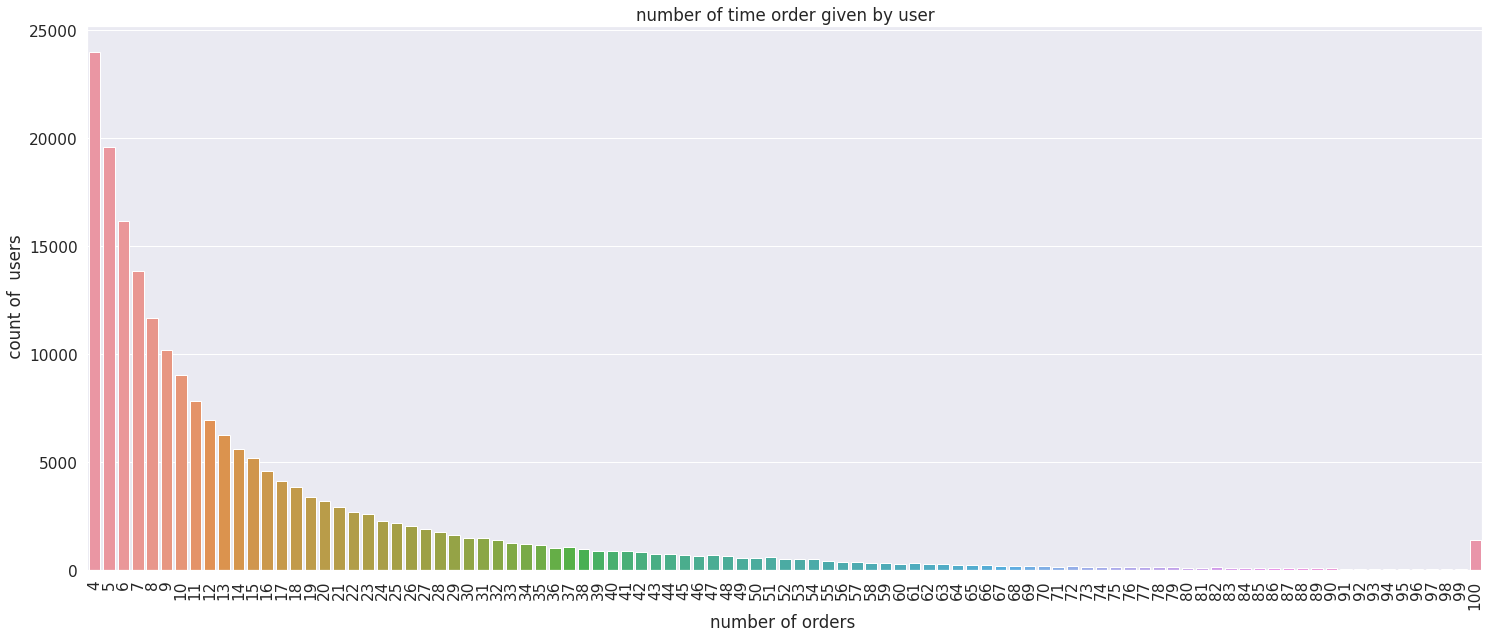

In [ ]:
sns.set(font_scale =1.4)
plt.figure(figsize=(25,10))
ax=sns.countplot(a.values)
plt.ylabel(" count of  users")
plt.xlabel("number of orders ")
plt.title("number of time order given by user")
plt.xticks(rotation='vertical')
plt.show()

observations:approximately 22000 user give order 4 times and  very  few user give order  more than 30 time.If number of order  by user is high than there is high probability of reordered .

In [ ]:
dict_count_user={}
for j in range(4,101):
  sum=0
  for i in a.values:
    if i==j:
      sum=sum+1
  dict_count_user[j]=sum   
print('number_of_order and count of user dictionary')
dict_count_user.items()

number_of_order and count of user dictionary


dict_items([(4, 23986), (5, 19590), (6, 16165), (7, 13850), (8, 11700), (9, 10190), (10, 9032), (11, 7815), (12, 6952), (13, 6236), (14, 5613), (15, 5191), (16, 4593), (17, 4139), (18, 3836), (19, 3390), (20, 3200), (21, 2921), (22, 2706), (23, 2605), (24, 2288), (25, 2186), (26, 2060), (27, 1908), (28, 1779), (29, 1601), (30, 1494), (31, 1474), (32, 1386), (33, 1273), (34, 1186), (35, 1157), (36, 1015), (37, 1048), (38, 960), (39, 904), (40, 878), (41, 885), (42, 814), (43, 743), (44, 724), (45, 707), (46, 657), (47, 675), (48, 654), (49, 579), (50, 554), (51, 582), (52, 527), (53, 524), (54, 499), (55, 425), (56, 390), (57, 396), (58, 343), (59, 332), (60, 303), (61, 324), (62, 276), (63, 267), (64, 254), (65, 239), (66, 238), (67, 204), (68, 189), (69, 185), (70, 178), (71, 154), (72, 166), (73, 138), (74, 162), (75, 162), (76, 134), (77, 120), (78, 127), (79, 127), (80, 116), (81, 108), (82, 119), (83, 86), (84, 99), (85, 100), (86, 93), (87, 78), (88, 79), (89, 77), (90, 85), (91,

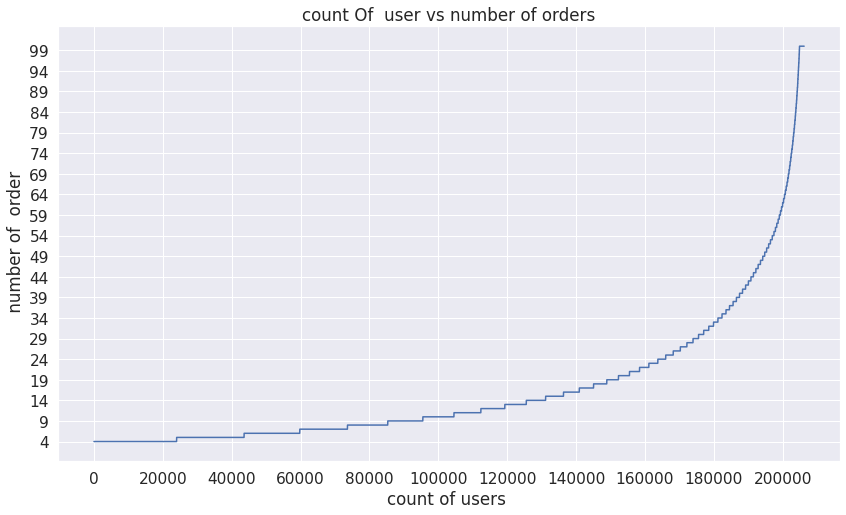

In [ ]:
plt.figure(figsize=(14,8))
plt.ylabel(" number of  order")
plt.xlabel("count of users ")
plt.title("count Of  user vs number of orders")
plt.xticks(np.arange(0, max(a.index), 20000))
plt.yticks(np.arange(4,max(a.values),5))
plt.plot(a.values)
plt.show()

OBSERVATION:In this graph it is clear that large number of user give order few time and very few user give orders many times.

In [ ]:
dict_cummulative_order_count={}
for j in range(10,101,10):
  sum=0
  for i in a.values:
    if i>j:
      sum=sum+1
  dict_cummulative_order_count[j]=sum
for c,b in dict_cummulative_order_count.items():      
  print('count of user more than ',c,'orders are',b)    

count of user more than  10 orders are 101696
count of user more than  20 orders are 50731
count of user more than  30 orders are 29183
count of user more than  40 orders are 17902
count of user more than  50 orders are 10910
count of user more than  60 orders are 6589
count of user more than  70 orders are 4235
count of user more than  80 orders are 2829
count of user more than  90 orders are 1905
count of user more than  100 orders are 0


-> ORDER_ID eval_set count

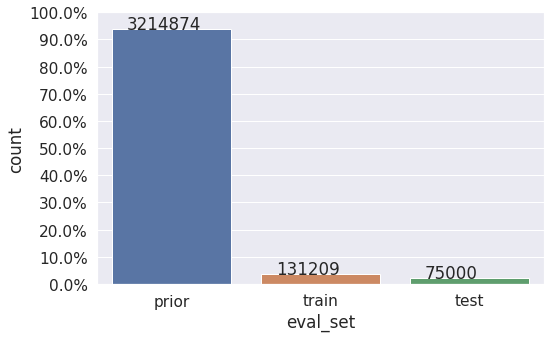

In [ ]:
#references from applied ai
sns.set(font_scale =1.4)
plt.figure(figsize=(8,5))
total = len(orders_data)*1.
ax=sns.countplot(x='eval_set',data=orders_data)
for p in ax.patches:
        #for put value on countplot graph,In the simplest form, the text is placed at xy.
        ax.annotate(p.get_height(), (p.get_x()+0.1, p.get_height()+5))
        
#put 11 ticks (therefore 10 steps), from 0 to the total number of rows in the dataframe
ax.yaxis.set_ticks(np.linspace(0, total, 11))

#adjust the ticklabel to the desired format, without changing the position of the ticks. 
ax.set_yticklabels(map('{:.1f}%'.format, 100*ax.yaxis.get_majorticklocs()/total))
plt.show()

OBSERVATIONS:we have approximately 92%(3214874) order_id in prior while 131209 in train and 75000 in test

->order  at day of week count

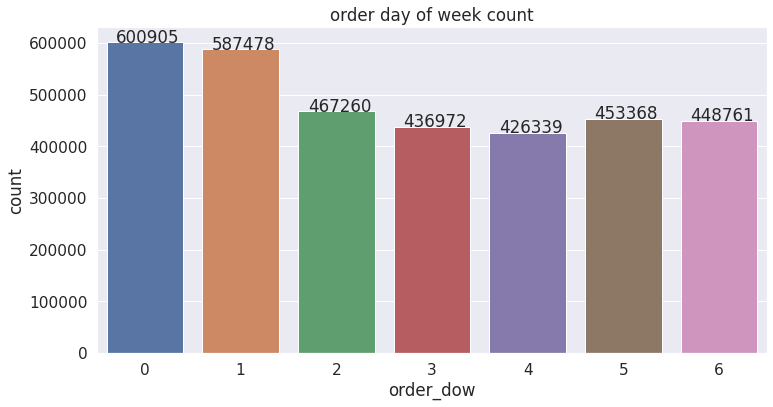

In [ ]:
sns.set(font_scale =1.4)
plt.figure(figsize=(12,6))
ax=sns.countplot(x='order_dow',data=orders_data)
plt.title("order day of week count")
for p in ax.patches:
         #for put value on countplot graph,In the simplest form, the text is placed at xy cordinate.
        ax.annotate(p.get_height(),  (p.get_x()+0.1, p.get_height()+5))
plt.show()

OBSERVATION:On day 0 and 1 orders are more than other days.Here , distribution is approximately equal in remaining days

->count of orders at hour of day

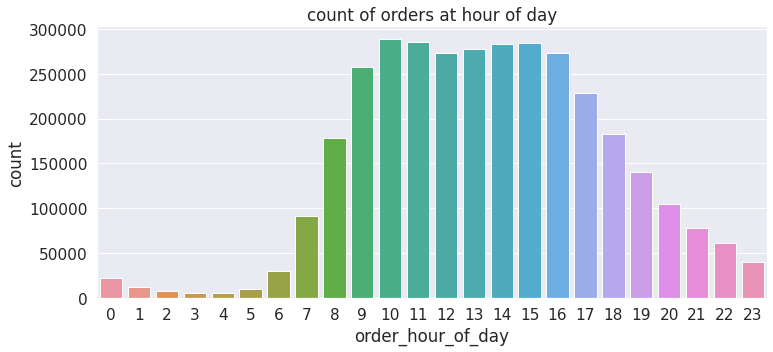

In [ ]:
sns.set(font_scale =1.4)
plt.figure(figsize=(12,5))
plt.xlabel('hour of day')
plt.ylabel("count of orders")
plt.title("count of orders at hour of day")
ax=sns.countplot(x='order_hour_of_day',data=orders_data)
plt.show()

OBSERVATION:In between 8 to 18 hours orders are more.

->gap between 2 orders

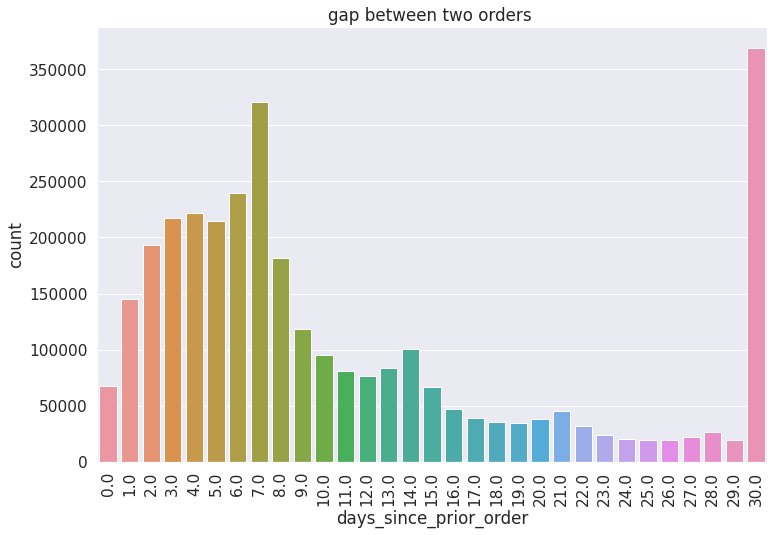

In [ ]:
sns.set(font_scale =1.4)
plt.figure(figsize=(12,8))
ax=sns.countplot(x='days_since_prior_order',data=orders_data)
plt.title("gap between two orders ")
plt.xticks(rotation='vertical')
plt.show()

OBSERVATION:here many customer prefer shopping after weekly basis or monthly basis after last order.

->count of reordered and ordered

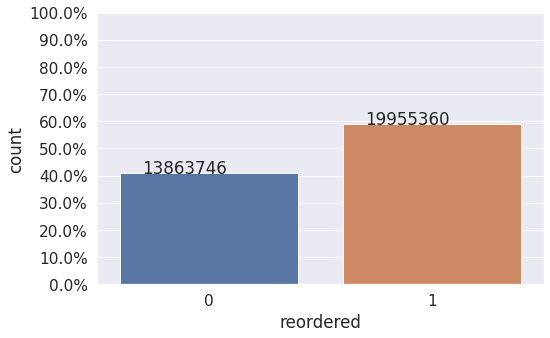

In [ ]:
sns.set(font_scale =1.4)
plt.figure(figsize=(8,5))
total = len(order_train_prior)*1.
ax=sns.countplot(x='reordered',data=order_train_prior)
for p in ax.patches:
        ax.annotate(p.get_height(), (p.get_x()+0.1, p.get_height()+5))
        
#put 11 ticks (therefore 10 steps), from 0 to the total number of rows in the dataframe
ax.yaxis.set_ticks(np.linspace(0, total, 11))

#adjust the ticklabel to the desired format, without changing the position of the ticks. 
ax.set_yticklabels(map('{:.1f}%'.format, 100*ax.yaxis.get_majorticklocs()/total))
plt.show()

OBSERVATION:  Approximately 59% products are reordered and 41% are not reordered by users.

# ANALYSIS OF PRODUCTS IN ORDER

In [ ]:
data.columns

Index(['order_id', 'user_id', 'eval_set', 'order_number', 'order_dow',
       'order_hour_of_day', 'days_since_prior_order', 'product_id',
       'add_to_cart_order', 'reordered'],
      dtype='object')

->products in each order

In [ ]:
proucts_in_orders=data.groupby("order_id")["add_to_cart_order"].max().reset_index()
proucts_in_orders.head()

,order_id,add_to_cart_order
0,1,8
1,2,9
2,3,8
3,4,13
4,5,26


Text(0, 0.5, 'count')

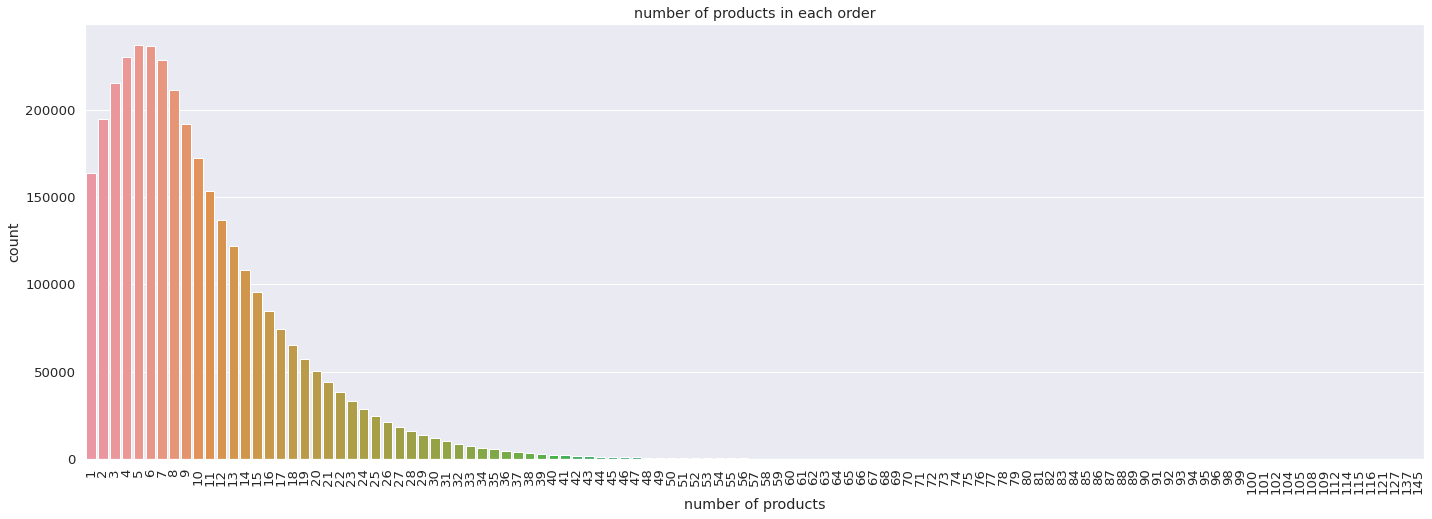

In [ ]:
sns.set(font_scale =1.2)
plt.figure(figsize=(24,8))
plt.xticks(rotation='vertical')
plt.title("number of products in each order")
sns.countplot(x=proucts_in_orders["add_to_cart_order"])
plt.xlabel("number of products")
plt.ylabel("count")

Observation: as we can see from above graph in many orders there are 1 to 12 products.

 ->product count at day of week

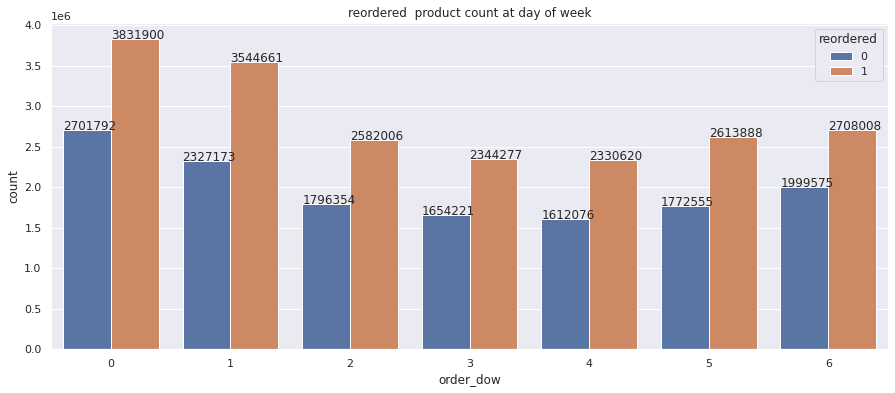

In [ ]:
sns.set(font_scale =1)
plt.figure(figsize=(18,6))
ax = sns.countplot(x="order_dow", data=data,hue='reordered')
plt.title('product count at day of week')
for p in ax.patches:
        #for put value on countplot graph,In the simplest form, the text is placed at xy.
        ax.annotate(p.get_height(), (p.get_x(), p.get_height()+5))
plt.show()

Observation:

(i) reordered of products are also more on day 0 and 1 because on day 0 and 1 have more orders .

(ii)On other days reordered of products are approximately same distributed.

->Bivariate analysis with order_dow and order_hour_of_day

Text(0.5, 1.0, 'bivariate analysis of order_dow vs order_hour_of_day')

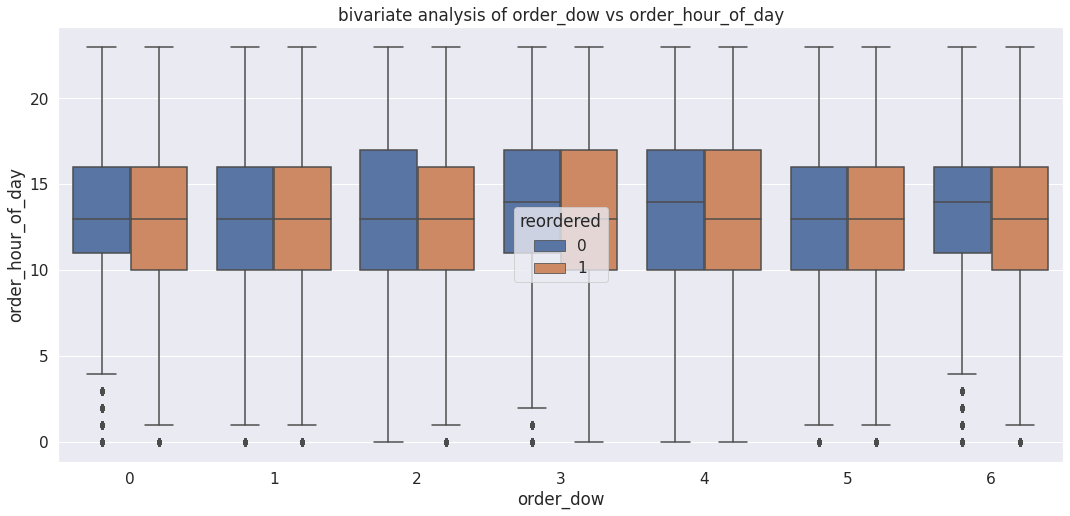

In [ ]:
sns.set(font_scale =1.4)
plt.figure(figsize=(18,8))
sns.boxplot(x='order_dow',y='order_hour_of_day',hue='reordered',data=data)
plt.title("bivariate analysis of order_dow vs order_hour_of_day")

Observation:

(i)From above box plot it is clear that medians of order_hour_or_day for reordered and  ordered products between 12 to 14 for all days of week.

(ii)In all days ordered and reordered product purchase more in between 10 to 17 hour_Of_day.

order_hour_of_day     0      1     2     3   ...      20     21     22     23
order_dow                                    ...                             
0                  23318  13088  7527  5330  ...  115072  98382  76120  44776
1                  22759  11165  6198  4207  ...   90926  72658  54793  34180
2                  17498   8545  4913  4252  ...   77343  62000  47764  31243
3                  15800   7607  4951  3349  ...   73614  60623  49531  29857
4                  14335   7713  4601  3702  ...   80411  67168  54619  32430
5                  16958   8846  5550  4761  ...   76840  61526  48667  32616
6                  18335  10802  6628  4531  ...   79117  69207  56496  38287

[7 rows x 24 columns]


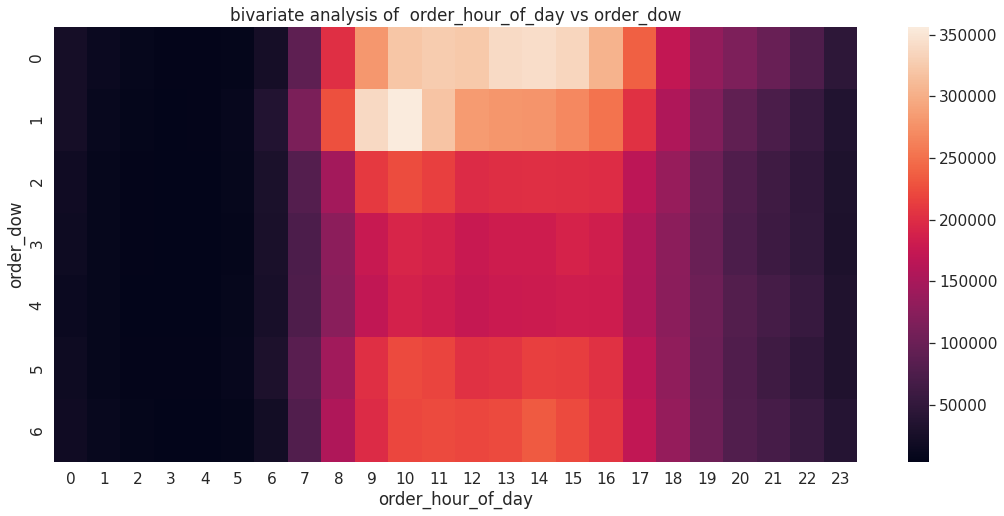

In [ ]:
result = pd.pivot_table(data=data, index='order_dow', columns='order_hour_of_day',values='reordered',aggfunc=np.sum)
print(result)
plt.figure(figsize=(18,8))
plt.title("bivariate analysis of  order_hour_of_day vs order_dow")
sns.heatmap(result)
plt.show()

Observation:On day 0 and 1 there is more number of purchased in morning compare to other days.

order_hour_of_day        0         1         2   ...        21        22        23
order_dow                                        ...                              
0                  0.576550  0.553474  0.554843  ...  0.608958  0.599885  0.598522
1                  0.590223  0.591805  0.556773  ...  0.582751  0.577297  0.577697
2                  0.565236  0.560328  0.565167  ...  0.579992  0.572223  0.574320
3                  0.554133  0.535516  0.543409  ...  0.581025  0.583596  0.569703
4                  0.556915  0.540088  0.545530  ...  0.595699  0.583805  0.571182
5                  0.548980  0.550912  0.560946  ...  0.595490  0.592294  0.580418
6                  0.556838  0.565372  0.560270  ...  0.588330  0.587386  0.581613

[7 rows x 24 columns]


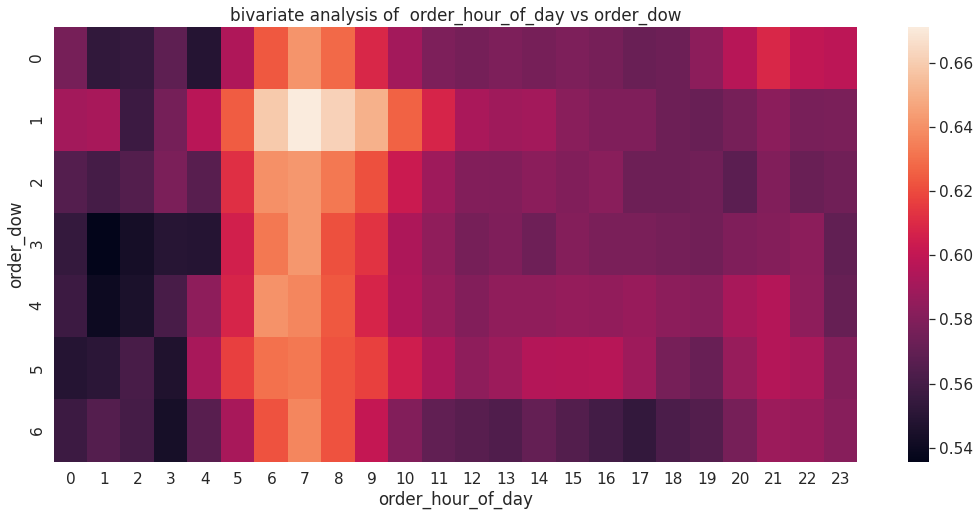

In [ ]:
result = pd.pivot_table(data=data, index='order_dow', columns='order_hour_of_day',values='reordered')
print(result)
plt.figure(figsize=(18,8))
plt.title("bivariate analysis of  order_hour_of_day vs order_dow")
sns.heatmap(result,color='red')
plt.show()

Observation:(i)reordered ratio is high in 6,7,8 hour_of_day for all day_of_week

(ii)high reordered ratio is on day 1 in 6,7,8 hour_of_day.

#Analysis on reoredered product
 Filter above  data where reordered=1

In [ ]:
reorderd_product_data=data4[data4.reordered==1]
reorderd_product_data.shape

(19955360, 15)

In [ ]:
reorderd_product_data.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,department,aisle
1,2398795,1,prior,2,3,7,15.0,196,1,1,Soda,77,7,beverages,soft drinks
2,473747,1,prior,3,3,12,21.0,196,1,1,Soda,77,7,beverages,soft drinks
3,2254736,1,prior,4,4,7,29.0,196,1,1,Soda,77,7,beverages,soft drinks
4,431534,1,prior,5,4,15,28.0,196,1,1,Soda,77,7,beverages,soft drinks
5,3367565,1,prior,6,2,7,19.0,196,1,1,Soda,77,7,beverages,soft drinks


->count of reordered product at hour of day

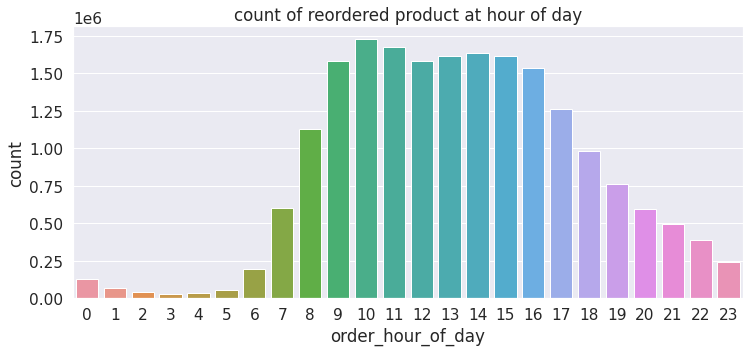

In [ ]:
sns.set(font_scale =1.4)
plt.figure(figsize=(12,5))
plt.xlabel('hour of day')
plt.ylabel("count of orders")
plt.title("count of reordered product at hour of day")
ax=sns.countplot(x='order_hour_of_day',data=reorderd_product_data)
plt.show()

observation: products are reorderd more in 9 to 16 hour_of_day.

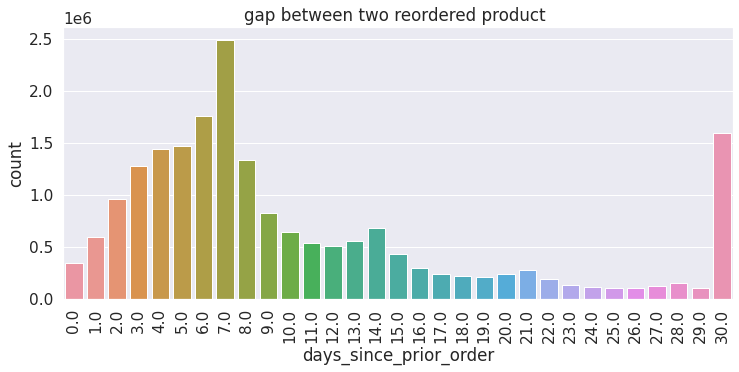

In [ ]:
sns.set(font_scale =1.4)
plt.figure(figsize=(12,5))
ax=sns.countplot(x='days_since_prior_order',data=reorderd_product_data)
plt.title("gap between two reordered product ")
plt.xticks(rotation='vertical')
plt.show()

observation: reordered of products are more after 7 days or 30 days.

Top ten products reordered after 7 days of last order

In [ ]:
top_ten_product_reorder_after_7_days=reorderd_product_data[reorderd_product_data.days_since_prior_order==7]['product_name'].value_counts(sort=True,ascending=False)
print("top ten reordered products after 7 days are")
print("*"*50)
top_ten_product_reorder_after_7_days[:10]

top ten reordered products after 7 days are
**************************************************


Banana                    55553
Bag of Organic Bananas    40399
Organic Strawberries      25625
Organic Baby Spinach      23623
Organic Hass Avocado      20865
Organic Avocado           17971
Organic Whole Milk        14442
Large Lemon               14412
Strawberries              13705
Organic Raspberries       13136
Name: product_name, dtype: int64

Top ten reordered aisle after 7 days of last order

In [ ]:
top_ten_aisle_reorder_after_7_days=reorderd_product_data[reorderd_product_data.days_since_prior_order==7]['aisle'].value_counts(sort=True,ascending=False)
print("top ten reordered aisle after 7 days are")
print("*"*50)
top_ten_aisle_reorder_after_7_days[:10]

top ten reordered aisle after 7 days are
**************************************************


fresh fruits                     359469
fresh vegetables                 257628
packaged vegetables fruits       148009
yogurt                           142108
milk                              90325
water seltzer sparkling water     77863
packaged cheese                   74503
chips pretzels                    57775
soy lactosefree                   56612
bread                             48779
Name: aisle, dtype: int64

Observation:Top ten reordered product after 7 days from fruit,milk and vegetables aisle

Top ten products reordered after 30 days of last order

In [ ]:
top_ten_product_reorder_after_30_days=reorderd_product_data[reorderd_product_data.days_since_prior_order==30]['product_name'].value_counts(sort=True,ascending=False)
print("top ten reordered products after 30 days are")
print("*"*30)
top_ten_product_reorder_after_30_days[:10]

top ten reordered products after 30 days are
******************************


Banana                    36628
Bag of Organic Bananas    22482
Organic Baby Spinach      17495
Organic Strawberries      14135
Organic Avocado           12421
Organic Hass Avocado      12201
Large Lemon               10378
Limes                      8631
Strawberries               8402
Organic Whole Milk         7958
Name: product_name, dtype: int64

Observation:
(i)Top ten reordered products after 7 days and 30 days are  almost simillar except 2 products remianing 8 produts are highly reordered after 7 days and 30 days .So , it is better if instacart has good number of this products in store after 7 and 30 days .

Top ten departement which receive maximum reordered after 30 days of last order

In [ ]:
top_ten_department_reorder_after_30_days=reorderd_product_data[reorderd_product_data.days_since_prior_order==30]['department'].value_counts(sort=True,ascending=False)
print("top ten department which receive many reordered  after 30 days are")
print("*"*50)
top_ten_department_reorder_after_30_days[:10]

top ten department which receive many reordered  after 30 days are
**************************************************


produce            483089
dairy eggs         297368
beverages          152114
snacks             130588
frozen             116472
bakery              62773
pantry              57153
deli                56589
canned goods        44702
dry goods pasta     38614
Name: department, dtype: int64

Observation: Department produce ,dairy eggs,beaverages and snack receives many reordered after 30 days.

Top ten reordered product every day

In [ ]:
for b in range(0,7):
  top_ten_product_dow=reorderd_product_data[reorderd_product_data['order_dow']==b]['product_name'].value_counts(sort=True,ascending=False)
  print("top ten reordered product at day",b,"are")
  print("*"*50)  
  print(top_ten_product_dow[:10])
  print("*"*50)
  print("\n")

top ten reordered product at day 0 are
**************************************************
Banana                    85538
Bag of Organic Bananas    62553
Organic Baby Spinach      44594
Organic Strawberries      44399
Organic Hass Avocado      36458
Organic Avocado           31971
Large Lemon               25092
Organic Whole Milk        22795
Limes                     21799
Organic Raspberries       21174
Name: product_name, dtype: int64
**************************************************


top ten reordered product at day 1 are
**************************************************
Banana                    77042
Bag of Organic Bananas    60322
Organic Strawberries      37229
Organic Baby Spinach      33754
Organic Hass Avocado      31611
Organic Avocado           25409
Organic Whole Milk        20095
Large Lemon               19647
Organic Raspberries       19308
Strawberries              18692
Name: product_name, dtype: int64
**************************************************


top ten 

Observatiom: In all days Banana,
Bag of Organic Bananas ,
Organic Strawberries ,
Organic Baby Spinach ,
Organic Hass Avocado are reordered maximum time.

Top ten reordered aisle at all day

In [ ]:
for b in range(0,7):
  top_ten_product_aisle=reorderd_product_data[reorderd_product_data['order_dow']==b]['aisle'].value_counts(sort=True,ascending=False)
  print("top ten reordered aisle at day",b,"are")
  print("*"*50)  
  print(top_ten_product_aisle[:10])
  print("*"*50)
  print("\n")

top ten reordered aisle at day 0 are
**************************************************
fresh fruits                     539101
fresh vegetables                 467264
packaged vegetables fruits       248811
yogurt                           193668
milk                             131276
packaged cheese                  119339
water seltzer sparkling water    101956
soy lactosefree                   85577
bread                             80143
chips pretzels                    77012
Name: aisle, dtype: int64
**************************************************


top ten reordered aisle at day 1 are
**************************************************
fresh fruits                     500937
fresh vegetables                 364779
packaged vegetables fruits       208093
yogurt                           193188
milk                             129062
water seltzer sparkling water    122143
packaged cheese                  105321
soy lactosefree                   82396
chips pretzels           

Observatiom:fresh fruits ,fresh vegetables ,packaged vegetables fruits,yogurt ,milk  ,
packaged cheese ,water seltzer sparkling water ,soy lactosefree ,chips pretzels 
are common top 9 aisle while top tenth aisle is bread at 0,1,6 days and refrigerated on remaining days.

Top 5 reordered product at  all hour of day

In [ ]:
for b in range(0,24):
  top_five_product_hod=reorderd_product_data[reorderd_product_data['order_hour_of_day']==b]['product_name'].value_counts(sort=True,ascending=False)
  print("top five reordered product at hour",b,"are")
  print("*"*50)  
  print(top_five_product_hod[:5])
  print("*"*50)
  print("\n")

top five reordered product at hour 0 are
**************************************************
Banana                    2406
Bag of Organic Bananas    2350
Organic Strawberries      1413
Organic Baby Spinach      1406
Organic Hass Avocado      1138
Name: product_name, dtype: int64
**************************************************


top five reordered product at hour 1 are
**************************************************
Banana                    1192
Bag of Organic Bananas    1188
Organic Baby Spinach       769
Organic Strawberries       686
Organic Hass Avocado       553
Name: product_name, dtype: int64
**************************************************


top five reordered product at hour 2 are
**************************************************
Banana                    721
Bag of Organic Bananas    672
Organic Baby Spinach      394
Organic Strawberries      363
Organic Hass Avocado      321
Name: product_name, dtype: int64
**************************************************


top fi

Observation: Banana ,Bag of Organic Bananas  ,  Organic Strawberries ,Organic Baby Spinach,Organic Hass Avocado are top 5 products maximum reorder at all hour of day

Top five reorederd aisle at all hour of day

In [ ]:
for b in range(0,24):
  top_five_aisle_hod=reorderd_product_data[reorderd_product_data['order_hour_of_day']==b]['aisle'].value_counts(sort=True,ascending=False)
  print("top five reordered aisle at hour",b,"are")
  print("*"*50)  
  print(top_five_aisle_hod[:5])
  print("*"*50)
  print("\n")

top five reordered aisle at hour 0 are
**************************************************
fresh fruits                  17974
fresh vegetables              15522
packaged vegetables fruits     8147
yogurt                         6278
milk                           4226
Name: aisle, dtype: int64
**************************************************


top five reordered aisle at hour 1 are
**************************************************
fresh fruits                  9007
fresh vegetables              8211
packaged vegetables fruits    4301
yogurt                        3032
milk                          2143
Name: aisle, dtype: int64
**************************************************


top five reordered aisle at hour 2 are
**************************************************
fresh fruits                  5239
fresh vegetables              4599
packaged vegetables fruits    2424
yogurt                        1860
milk                          1232
Name: aisle, dtype: int64
****************

Obsevation:Top 5 reordered aisle are  fresh fruits ,
fresh vegetables ,
packaged vegetables fruits ,
yogurt  ,
milk  in all hour of day

# Analysis on product

->How many time each products purchased

In [7]:
product_count=data2['product_name'].value_counts(sort=True,ascending=True)

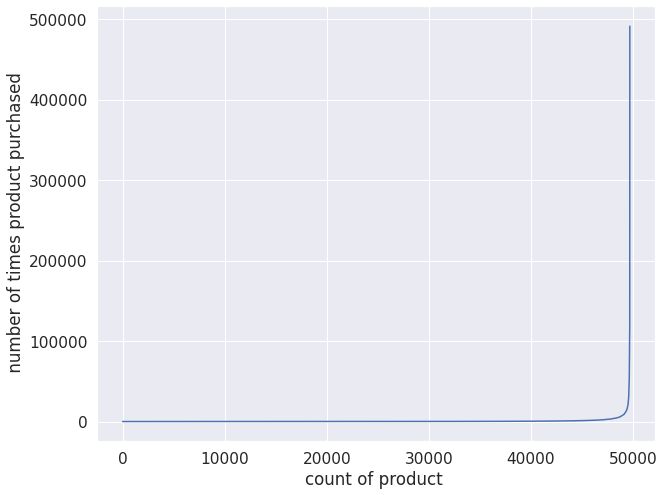

In [ ]:
plt.figure(figsize=(10,8))
plt.ylabel(" number of times product purchased")
plt.xlabel("count of product ")
plt.plot(product_count.values)
plt.show()

In [ ]:
dictionary_product_purchase={}
for j in range(1,10002,1000):
  sum=0
  for i in product_count.values:
    if i<=j:
      sum=sum+1
  dictionary_product_purchase[j]=sum
for c,b in dictionary_product_purchase.items():      
  print('count of product purchassed less than or equal to ',c,' time are',b)

count of product purchassed less than or equal to  1  time are 102
count of product purchassed less than or equal to  1001  time are 44453
count of product purchassed less than or equal to  2001  time are 46774
count of product purchassed less than or equal to  3001  time are 47715
count of product purchassed less than or equal to  4001  time are 48200
count of product purchassed less than or equal to  5001  time are 48536
count of product purchassed less than or equal to  6001  time are 48745
count of product purchassed less than or equal to  7001  time are 48889
count of product purchassed less than or equal to  8001  time are 49011
count of product purchassed less than or equal to  9001  time are 49115
count of product purchassed less than or equal to  10001  time are 49174


In [ ]:
sum=0
for i in product_count.values:
    if i>=10000:
        sum=sum+1
print('number of products purchased more than 100000 times are',sum)

number of products purchased more than 100000 times are 511


In [ ]:
sum=0
for i in product_count.values:
    if i==1:
        sum=sum+1
print('number of products purchased only one times are',sum)        

number of products purchased only one times are 102


observation: Many products purchased few times while only 511 products purchased more than 10,000 time.

-> Top ten highest purchsed products 

In [ ]:
product_count[-1:-11:-1]

Banana                    491291
Bag of Organic Bananas    394930
Organic Strawberries      275577
Organic Baby Spinach      251705
Organic Hass Avocado      220877
Organic Avocado           184224
Large Lemon               160792
Strawberries              149445
Limes                     146660
Organic Whole Milk        142813
Name: product_name, dtype: int64

Text(0.5, 1.0, ' top ten products and their number of purchase')

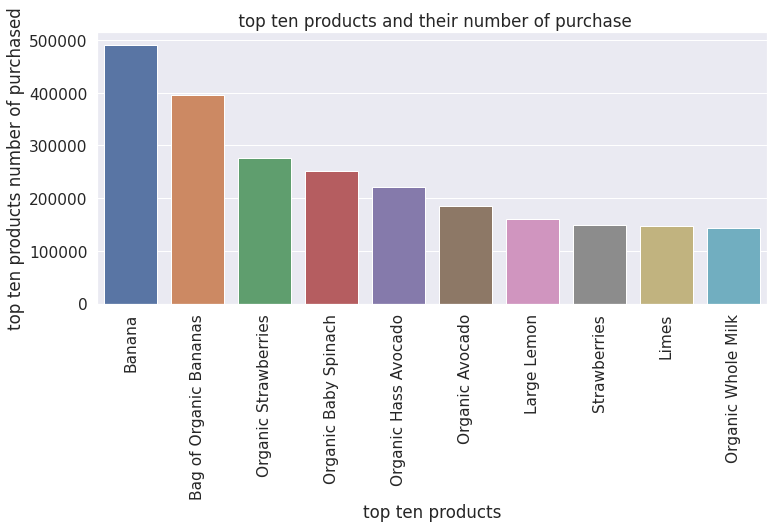

In [ ]:
sns.set(font_scale =1.4)
plt.figure(figsize=(12,5))
plt.xticks(rotation='vertical')
sns.barplot(x=product_count.index[-1:-11:-1] , y=product_count.values[-1:-11:-1] )
plt.xlabel('top ten products')
plt.ylabel("top ten products number of purchased")
plt.title(" top ten products and their number of purchase")

observation:Top ten highest purchsed products are Fruits,vegetables and milk 

->Top ten product with heighest reordered ratio 

In [ ]:
top_ten_product_reordered_ratio = data2.groupby(["product_name"])["reordered"].mean().to_frame("ratio").reset_index()
top_ten_product_reordered_ratio.sort_values(by='ratio', ascending=False,inplace=True)
top_ten_product_reordered_ratio.head(10)

,product_name,ratio
37379,Raw Veggie Wrappers,0.942029
39870,Serenity Ultimate Extrema Overnight Pads,0.933333
28415,Orange Energy Shots,0.923077
8537,Chocolate Love Bar,0.921569
41723,Soy Powder Infant Formula,0.914286
40458,Simply Sleep Nighttime Sleep Aid,0.911111
13844,"Energy Shot, Grape Flavor",0.909091
38793,Russian River Valley Reserve Pinot Noir,0.900000
3832,Bars Peanut Butter,0.898551
41712,Soy Crisps Lightly Salted,0.895522


observation:Here, top ten high reordered ratio  products are different from top ten high purchased products.

# Analysis on department

->department with  orders of products

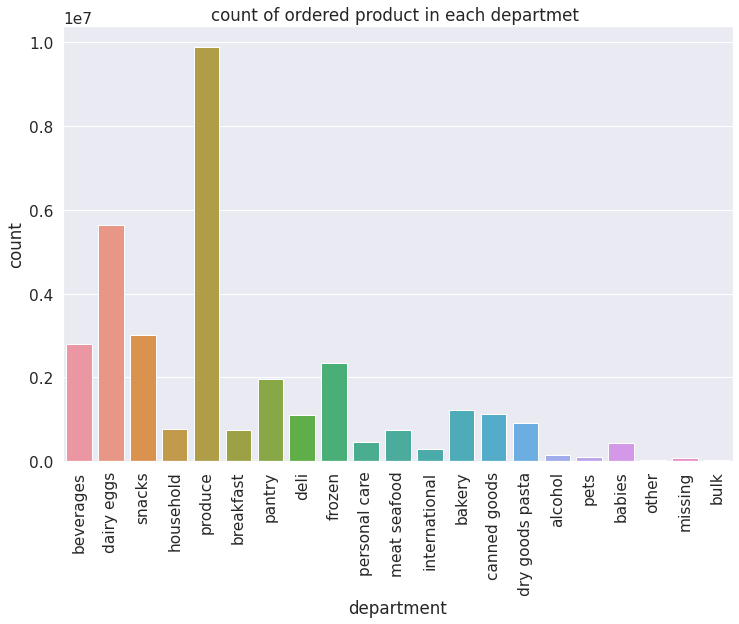

In [ ]:
sns.set(font_scale =1.4)
plt.figure(figsize=(12,8))
ax=sns.countplot(x='department',data=data3)
plt.xticks(rotation='vertical')
plt.title("count of ordered product in each departmet ")
plt.show()

observation: from department produce and dairy eggs  more number of product purchased.

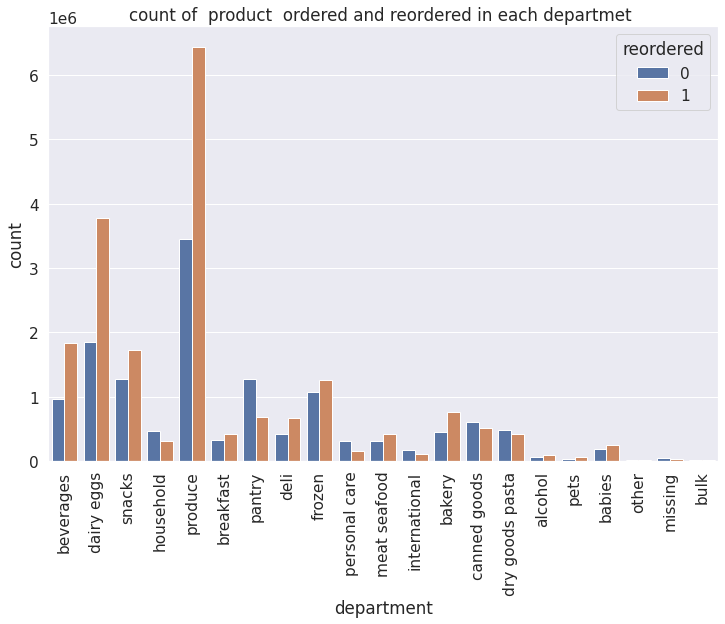

In [ ]:
sns.set(font_scale =1.4)
plt.figure(figsize=(12,8))
ax=sns.countplot(x='department',data=data3,hue='reordered')
plt.xticks(rotation='vertical')
plt.title("count of  product  ordered and reordered in each departmet ")
plt.show()

observation:department produce,dairy eggs,beverages and snacks receives more reorder of product

# Analysis on aisle

->top 15 aisle  analysis

In [ ]:
aisle_count=data4['aisle'].value_counts(sort=True)
print("top 15 aisles are")
print("**************************")
aisle_count[0:15]

top 15 aisles are
**************************


fresh fruits                     3792661
fresh vegetables                 3568630
packaged vegetables fruits       1843806
yogurt                           1507583
packaged cheese                  1021462
milk                              923659
water seltzer sparkling water     878150
chips pretzels                    753739
soy lactosefree                   664493
bread                             608469
refrigerated                      599109
frozen produce                    545107
ice cream ice                     521101
crackers                          478430
energy granola bars               473835
Name: aisle, dtype: int64

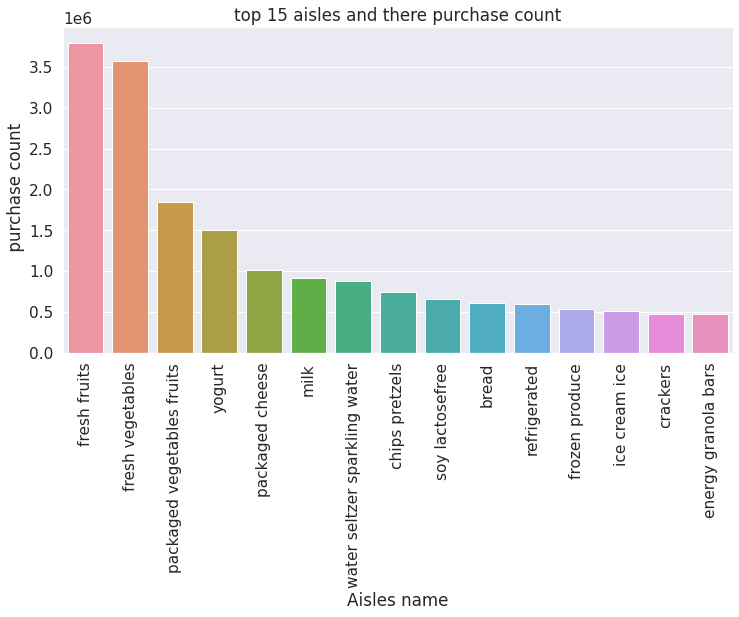

In [ ]:
sns.set(font_scale =1.4)
plt.figure(figsize=(12,6))
sns.barplot(x=aisle_count[0:15].index , y=aisle_count[0:15].values )
plt.title("top 15 aisles and there purchase count")
plt.xlabel("Aisles name")
plt.ylabel(" purchase count")
plt.xticks(rotation='vertical')
plt.show()

observation:fresh fruits and vegetables are highly purchased aisle.

Summary:

(i)As number of order is high and number of products are high in each order than there is high probability of reordered 

(ii)Reordered of products are more in day  0 and 1 between 10 to 17 hours_of_day.

(iii)For some products,aisle and department  have very high number of reordered counts while others have very few.

(iv)The products which has  high number of total  reordered that product also reordered maximum at all day of week,all hour of day and after 7 and 30 days.